## Rainfall in Southeastern Brazil - CHIRPS data set

## Overview

- Could precipitation explain the differences in air pollution levels during COVID-19 lock down? (apparently it couldn't!)

## Initial setup 

In [1]:
%%time

# Load packages.
import sys
import os
import h5py
import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import seaborn as sns

from dask.diagnostics import ProgressBar
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy import feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

warnings.filterwarnings("ignore")
xr.set_options(display_style="text")
%matplotlib inline

CPU times: user 1.46 s, sys: 316 ms, total: 1.78 s
Wall time: 2.39 s


In [2]:
%%time

print(">>> Versions:")
print("* numpy:", np.__version__)
print("* pandas:", pd.__version__)
print("* xarray:", xr.__version__)
print("\n>>> Computer:")
!echo "* Hostname: ${HOSTNAME}"
!echo "* User: ${USER}"
!echo "* Directory: $(pwd)"
!echo "* Date: $(date)"
!echo "* CPUs: $(nproc)"

>>> Versions:
* numpy: 1.19.1
* pandas: 1.1.1
* xarray: 0.16.0

>>> Computer:
* Hostname: n008
* User: sandroal
* Directory: /work/sandroal/notebooks/covid_19
* Date: Mon Nov 16 23:05:39 BRST 2020
* CPUs: 40
CPU times: user 16 ms, sys: 36 ms, total: 52 ms
Wall time: 632 ms


In [3]:
# Main directory.
DATA_FOLDER = "/work/sandroal/data_sets/CHIRPS/GLOBAL_DAILY_005DEG/"

# Where figures will be put.
FIG_PATH = "/work/sandroal/images/covid19/"

# Final results.
save_fig = True

# Map borders for Southeastern Brazil region.
loni, lonf, lati, latf = -55, -40, -30, -15

In [4]:
%%time

# My repository.
repository = "/work/sandroal/cdlearn/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Work in progress.
import cdlearn

CPU times: user 1.66 s, sys: 328 ms, total: 1.99 s
Wall time: 2.72 s


In [5]:
%%time

# First we will use cartopy's shapereader to download (and cache) states shapefile with 50 
# meters resolution from the NaturalEarth.
kw = dict(resolution="50m", category="cultural", name="admin_1_states_provinces")
states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

CPU times: user 36 ms, sys: 4 ms, total: 40 ms
Wall time: 38.8 ms


In [6]:
# All hdf5 data files.
FILES = sorted(glob.glob(DATA_FOLDER + "/*.nc"))

print(">>>", len(FILES), "data files inside", DATA_FOLDER + ":")
print("...")
for FILE in FILES[-5:]:
    print("*", os.path.basename(FILE))

>>> 40 data files inside /work/sandroal/data_sets/CHIRPS/GLOBAL_DAILY_005DEG/:
...
* chirps-v2.0.2016.days_p05.nc
* chirps-v2.0.2017.days_p05.nc
* chirps-v2.0.2018.days_p05.nc
* chirps-v2.0.2019.days_p05.nc
* chirps-v2.0.2020.days_p05.nc


## Load data for Southeastern Brazil

In [7]:
%%time

# Lazy read.
DS = xr.open_mfdataset(
    paths=FILES,
    concat_dim="time",
    combine="nested",
    chunks={}
)

# Same period as OMI.
DS = DS.sel(time=slice("2005", "2020"))

# Rename coordinates and dimensions.
DS = DS.rename({"precip": "precipitation", "latitude": "lat", "longitude": "lon"})

# Change order of dimensions.
DS = DS.transpose("time", "lat", "lon")

# Southeastern Brazil.
DS = DS.sel(lat=slice(lati, latf), lon=slice(loni, lonf))

# Show it.
print("\n>>>> Size in GB:", DS.nbytes / 1e9)
print("\n>>> Dataset:", DS)


>>>> Size in GB: 2.070768416

>>> Dataset: <xarray.Dataset>
Dimensions:        (lat: 300, lon: 300, time: 5752)
Coordinates:
  * lon            (lon) float32 -54.975006 -54.925003 ... -40.074997 -40.02501
  * lat            (lat) float32 -29.975 -29.925 ... -15.075001 -15.025002
  * time           (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2020-09-30
Data variables:
    precipitation  (time, lat, lon) float32 dask.array<chunksize=(365, 300, 300), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-11-20
    creator_name:      Pete Peterson
    creator_email:     pete@geog.ucsb.edu
    institution:       Climate Hazards Group.  University of California at Sa...
    documentation:     http://pubs.usgs.gov/ds/832/
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           

In [8]:
# Into memory.
with ProgressBar():
    DS = DS.compute()

[########################################] | 100% Completed | 29.3s


In [9]:
# For interpolation. Gain factor along latitude and longitude.
# This means squares smaller by a gain**2 factor.
gain = 1
        
# Interpolated grid.
lat1 = DS.lat[0].values
lat2 = DS.lat[-1].values
lon1 = DS.lon[0].values
lon2 = DS.lon[-1].values
dlat = np.diff(DS.lat[:2].values) / gain
dlon = np.diff(DS.lon[:2].values) / gain
grid={
    "lat": np.arange(lat1, lat2 + dlat, dlat), 
    "lon": np.arange(lon1, lon2 + dlon, dlon)
}

## Mean for whole time range

In [10]:
# Box around São Paulo City.
box_lat_i = -25.0; box_lat_f = -22.0; box_lon_i = -48.0; box_lon_f = -45.0 
box_dlat = box_lat_f - box_lat_i
box_dlon = box_lon_f - box_lon_i
box_lat_slice = slice(box_lat_i, box_lat_f)
box_lon_slice = slice(box_lon_i, box_lon_f)

CPU times: user 2.94 s, sys: 652 ms, total: 3.59 s
Wall time: 3.6 s


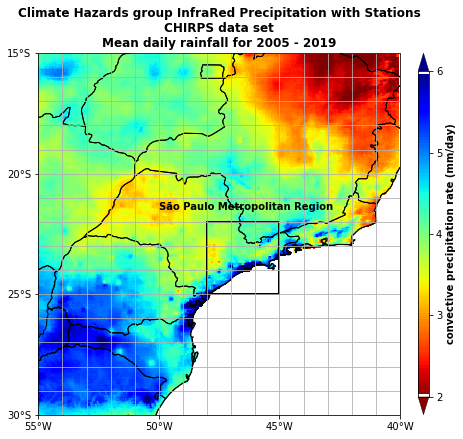

In [11]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(7, 7))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 1),
    axes_pad=0.5,''
    cbar_location="right",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-55, -40, -30, -15], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-55, -40 + 5, 5), crs=projection)
    axis.set_yticks(np.arange(-30, -15 + 5, 5), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-55, -40 + 1, 1), ylocs=range(-30, -15 + 1, 1))  
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )

# Mean for all time range available (complete yeras).
p = DS.precipitation.sel(time=slice("2005", "2019")).mean("time").\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=2.0,
    vmax=6.0,
    levels=np.arange(2.0, 6.0 + 0.04, 0.04),
    cmap=plt.cm.jet_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="both")
cb.set_label_text(f"{DS.precipitation.standard_name} ({DS.precipitation.units})", 
                  weight="bold")        

# Box around São Paulo city.
axgr[0].text(x=box_lon_i - 2, y=box_lat_f + 0.50, 
             s="São Paulo Metropolitan Region", color="black", weight="bold")
axgr[0].add_patch(mpatches.Rectangle(
    xy=[box_lon_i, box_lat_i], 
    width=box_dlon, 
    height=box_dlat,
    fill=None,
    lw=2,
    edgecolor="black",
    facecolor="black"
))
        
# Adjustments.
axgr[0].set_title(
    f"{DS.precipitation.long_name}\nCHIRPS data set\nMean daily rainfall for 2005 - 2019", 
    weight="bold"
)

if save_fig:
    plt.savefig(
        FIG_PATH + "precipitation_time_mean.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Define parameters for periods

In [12]:
%%time

# Dummy variable!
scale = 1

# For selecting data. Keys are years and values are slices of date strings.
p0s = {}; p1s = {}; p2s = {}
p3s = {}; p4s = {}; p5s = {}; p6s = {}

# For titles in figures. Keys are years and values are strings.
t0s = {}; t1s = {}; t2s = {}
t3s = {}; t4s = {}; t5s = {}; t6s = {}

# Loop over years.
for year in np.unique(DS.time.dt.year.values):
    
    # Same period for each year.
    p0s[year] = slice(str(year) + "-" + "02-12", str(year) + "-" + "03-13")
    t0s[year] = str(year) + "\nPeriod 0: February 12 - March 13"
    
    p1s[year] = slice(str(year) + "-" + "03-14", str(year) + "-" + "03-23")
    t1s[year] = str(year) + "\nPeriod 1: March 14 - March 23"

    p2s[year] = slice(str(year) + "-" + "03-24", str(year) + "-" + "04-03")
    t2s[year] = str(year) + "\nPeriod 2: March 24 - April 03"

    p3s[year] = slice(str(year) + "-" + "04-04", str(year) + "-" + "05-04")
    t3s[year] = str(year) + "\nPeriod 3: April 04 - May 04"

    p4s[year] = slice(str(year) + "-" + "05-05", str(year) + "-" + "06-05")
    t4s[year] = str(year) + "\nPeriod 4: May 05 - June 05"

    p5s[year] = slice(str(year) + "-" + "06-06", str(year) + "-" + "07-05")
    t5s[year] = str(year) + "\nPeriod 5: June 06 - July 05"

    p6s[year] = slice(str(year) + "-" + "07-06", str(year) + "-" + "08-05")
    t6s[year] = str(year) + "\nPeriod 6: July 06 - August 05"

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.87 ms


In [13]:
# Parameters for plots.
vmin = 0.0; vmax = 15.0     # Absolute concentrations.  
dvmin = -10.0; dvmax = 10.0 # Variations.  

## Period 0: 12/02 - 13/03

CPU times: user 2.4 s, sys: 28 ms, total: 2.42 s
Wall time: 2.43 s


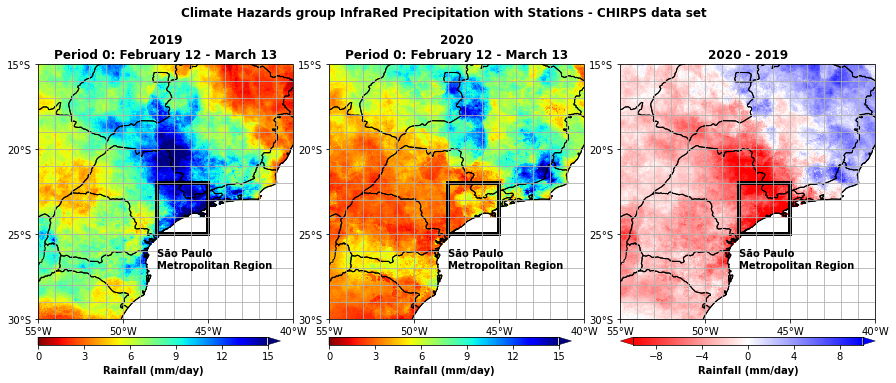

In [14]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 5.75))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 3),
    axes_pad=0.5,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Box around São Paulo city.
for axis in axgr:
    axis.text(x=-48, y=-27, 
              s="São Paulo\nMetropolitan Region", color="black", weight="bold")
    axis.add_patch(mpatches.Rectangle(
        xy=[box_lon_i, box_lat_i], 
        width=box_dlon, 
        height=box_dlat,
        fill=None,
        lw=4,
        edgecolor="black",
        facecolor="black"
    ))

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-55, -40, -30, -15], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-55, -40 + 5, 5), crs=projection)
    axis.set_yticks(np.arange(-30, -15 + 5, 5), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-55, -40 + 1, 1), ylocs=range(-30, -15 + 1, 1))  
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )      
            
# Period 0 for 2019.
p = DS.precipitation.sel(time=p0s[2019]).mean("time").\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="max")
cb.set_label_text(f"Rainfall ({DS.precipitation.units})", weight="bold")

# Period 0 for 2020.
p = DS.precipitation.sel(time=p0s[2020]).mean("time").\
    interp(coords=grid).plot(
    ax=axgr[1],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet_r,
    add_colorbar=False,
    add_labels=False
)             

# Fill color bar.
cb = axgr.cbar_axes[1].colorbar(p, extend="max")
cb.set_label_text(f"Rainfall ({DS.precipitation.units})", weight="bold")
    
# Difference between 2020 and 2019 .
p = (DS.precipitation.sel(time=p0s[2020]).mean("time") - \
     DS.precipitation.sel(time=p0s[2019]).mean("time")).\
    interp(coords=grid).plot(
    ax=axgr[2],
    vmin=dvmin,
    vmax=dvmax,
    cmap=plt.cm.bwr_r,
    add_colorbar=False,
    add_labels=False
)     

# Fill color bar.
cb = axgr.cbar_axes[2].colorbar(p, extend="both")
cb.set_label_text(f"Rainfall ({DS.precipitation.units})", weight="bold")

# Adjustments.
fig.suptitle(f"{DS.precipitation.long_name} - CHIRPS data set", weight="bold")
axgr[0].set_title(t0s[2019], weight="bold")
axgr[1].set_title(t0s[2020], weight="bold")
axgr[2].set_title("2020 - 2019", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "precipitation_p0_2019_2020.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Period 1: 14/03 - 23/03

CPU times: user 2.35 s, sys: 28 ms, total: 2.38 s
Wall time: 2.38 s


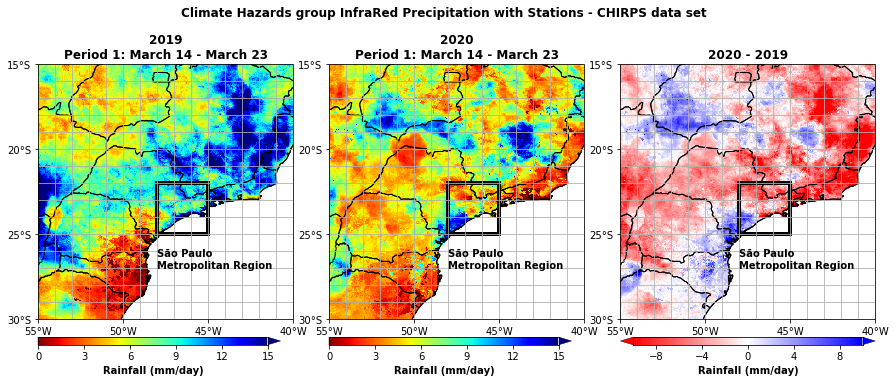

In [15]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 5.75))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 3),
    axes_pad=0.5,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Box around São Paulo city.
for axis in axgr:
    axis.text(x=-48, y=-27, 
              s="São Paulo\nMetropolitan Region", color="black", weight="bold")
    axis.add_patch(mpatches.Rectangle(
        xy=[box_lon_i, box_lat_i], 
        width=box_dlon, 
        height=box_dlat,
        fill=None,
        lw=4,
        edgecolor="black",
        facecolor="black"
    ))

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-55, -40, -30, -15], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-55, -40 + 5, 5), crs=projection)
    axis.set_yticks(np.arange(-30, -15 + 5, 5), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-55, -40 + 1, 1), ylocs=range(-30, -15 + 1, 1))  
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )      
            
# Period 1 for 2019.
p = DS.precipitation.sel(time=p1s[2019]).mean("time").\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="max")
cb.set_label_text(f"Rainfall ({DS.precipitation.units})", weight="bold")

# Period 1 for 2020.
p = DS.precipitation.sel(time=p1s[2020]).mean("time").\
    interp(coords=grid).plot(
    ax=axgr[1],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet_r,
    add_colorbar=False,
    add_labels=False
)             

# Fill color bar.
cb = axgr.cbar_axes[1].colorbar(p, extend="max")
cb.set_label_text(f"Rainfall ({DS.precipitation.units})", weight="bold")
    
# Difference between 2020 and 2019 .
p = (DS.precipitation.sel(time=p1s[2020]).mean("time") - \
     DS.precipitation.sel(time=p1s[2019]).mean("time")).\
    interp(coords=grid).plot(
    ax=axgr[2],
    vmin=dvmin,
    vmax=dvmax,
    cmap=plt.cm.bwr_r,
    add_colorbar=False,
    add_labels=False
)     

# Fill color bar.
cb = axgr.cbar_axes[2].colorbar(p, extend="both")
cb.set_label_text(f"Rainfall ({DS.precipitation.units})", weight="bold")

# Adjustments.
fig.suptitle(f"{DS.precipitation.long_name} - CHIRPS data set", weight="bold")
axgr[0].set_title(t1s[2019], weight="bold")
axgr[1].set_title(t1s[2020], weight="bold")
axgr[2].set_title("2020 - 2019", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "precipitation_p1_2019_2020.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Period 2: 24/03 - 03/04

CPU times: user 2.34 s, sys: 44 ms, total: 2.38 s
Wall time: 2.39 s


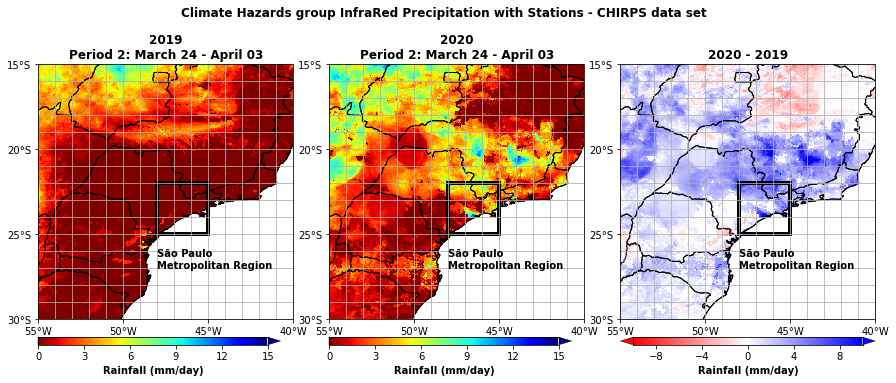

In [16]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 5.75))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 3),
    axes_pad=0.5,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Box around São Paulo city.
for axis in axgr:
    axis.text(x=-48, y=-27, 
              s="São Paulo\nMetropolitan Region", color="black", weight="bold")
    axis.add_patch(mpatches.Rectangle(
        xy=[box_lon_i, box_lat_i], 
        width=box_dlon, 
        height=box_dlat,
        fill=None,
        lw=4,
        edgecolor="black",
        facecolor="black"
    ))

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-55, -40, -30, -15], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-55, -40 + 5, 5), crs=projection)
    axis.set_yticks(np.arange(-30, -15 + 5, 5), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-55, -40 + 1, 1), ylocs=range(-30, -15 + 1, 1))  
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )      
            
# Period 2 for 2019.
p = DS.precipitation.sel(time=p2s[2019]).mean("time").\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="max")
cb.set_label_text(f"Rainfall ({DS.precipitation.units})", weight="bold")

# Period 2 for 2020.
p = DS.precipitation.sel(time=p2s[2020]).mean("time").\
    interp(coords=grid).plot(
    ax=axgr[1],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet_r,
    add_colorbar=False,
    add_labels=False
)             

# Fill color bar.
cb = axgr.cbar_axes[1].colorbar(p, extend="max")
cb.set_label_text(f"Rainfall ({DS.precipitation.units})", weight="bold")
    
# Difference between 2020 and 2019 .
p = (DS.precipitation.sel(time=p2s[2020]).mean("time") - \
     DS.precipitation.sel(time=p2s[2019]).mean("time")).\
    interp(coords=grid).plot(
    ax=axgr[2],
    vmin=dvmin,
    vmax=dvmax,
    cmap=plt.cm.bwr_r,
    add_colorbar=False,
    add_labels=False
)     

# Fill color bar.
cb = axgr.cbar_axes[2].colorbar(p, extend="both")
cb.set_label_text(f"Rainfall ({DS.precipitation.units})", weight="bold")

# Adjustments.
fig.suptitle(f"{DS.precipitation.long_name} - CHIRPS data set", weight="bold")
axgr[0].set_title(t2s[2019], weight="bold")
axgr[1].set_title(t2s[2020], weight="bold")
axgr[2].set_title("2020 - 2019", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "precipitation_p2_2019_2020.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Period 6: 06/07- 05/08

CPU times: user 2.45 s, sys: 24 ms, total: 2.48 s
Wall time: 2.48 s


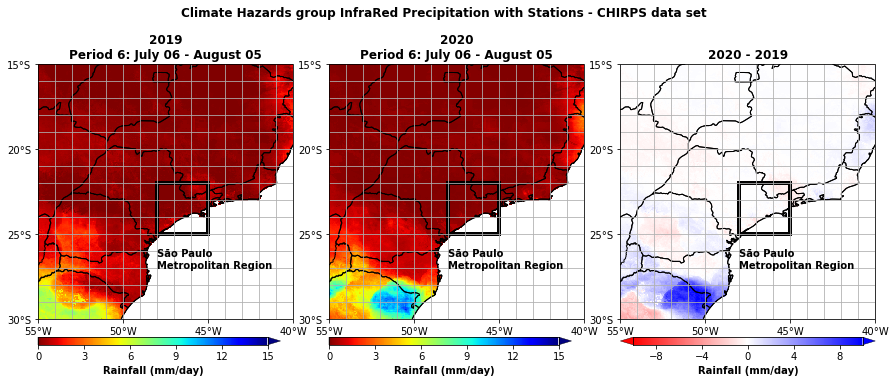

In [17]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 5.75))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 3),
    axes_pad=0.5,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Box around São Paulo city.
for axis in axgr:
    axis.text(x=-48, y=-27, 
              s="São Paulo\nMetropolitan Region", color="black", weight="bold")
    axis.add_patch(mpatches.Rectangle(
        xy=[box_lon_i, box_lat_i], 
        width=box_dlon, 
        height=box_dlat,
        fill=None,
        lw=4,
        edgecolor="black",
        facecolor="black"
    ))

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-55, -40, -30, -15], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-55, -40 + 5, 5), crs=projection)
    axis.set_yticks(np.arange(-30, -15 + 5, 5), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-55, -40 + 1, 1), ylocs=range(-30, -15 + 1, 1))  
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )      
            
# Period 6 for 2019.
p = DS.precipitation.sel(time=p6s[2019]).mean("time").\
    interp(coords=grid).plot(
    ax=axgr[0],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet_r,
    add_colorbar=False,
    add_labels=False
)          

# Fill color bar.
cb = axgr.cbar_axes[0].colorbar(p, extend="max")
cb.set_label_text(f"Rainfall ({DS.precipitation.units})", weight="bold")

# Period 6 for 2020.
p = DS.precipitation.sel(time=p6s[2020]).mean("time").\
    interp(coords=grid).plot(
    ax=axgr[1],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.jet_r,
    add_colorbar=False,
    add_labels=False
)             

# Fill color bar.
cb = axgr.cbar_axes[1].colorbar(p, extend="max")
cb.set_label_text(f"Rainfall ({DS.precipitation.units})", weight="bold")
    
# Difference between 2020 and 2019 .
p = (DS.precipitation.sel(time=p6s[2020]).mean("time") - \
     DS.precipitation.sel(time=p6s[2019]).mean("time")).\
    interp(coords=grid).plot(
    ax=axgr[2],
    vmin=dvmin,
    vmax=dvmax,
    cmap=plt.cm.bwr_r,
    add_colorbar=False,
    add_labels=False
)     

# Fill color bar.
cb = axgr.cbar_axes[2].colorbar(p, extend="both")
cb.set_label_text(f"Rainfall ({DS.precipitation.units})", weight="bold")

# Adjustments.
fig.suptitle(f"{DS.precipitation.long_name} - CHIRPS data set", weight="bold")
axgr[0].set_title(t6s[2019], weight="bold")
axgr[1].set_title(t6s[2020], weight="bold")
axgr[2].set_title("2020 - 2019", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "precipitation_p6_2019_2020.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Heatmaps

In [18]:
%%time

# Means as a pandas DataFrame object.
df_mean = pd.DataFrame()
df_mean_sp = pd.DataFrame()
periods = [p0s, p1s, p2s, p3s, p4s, p5s, p6s]
indexes = ["p0", "p1", "p2", "p3", "p4", "p5", "p6"]

# Loop over years and periods.
for year in np.unique(DS.time.dt.year.values):
    for period, index in zip(periods, indexes):
    
        # Get mean data for Southeastern Brazil.
        mean = DS.precipitation.sel(time=period[year]).mean().values.flatten()
        df_mean.loc[index, str(year)] = mean
        
        # Get mean data of São Paulo City.
        mean_sp = (DS.precipitation.sel(time=period[year]).\
                          sel(lat=box_lat_slice, lon=box_lon_slice).\
                          mean()).values.flatten()
        df_mean_sp.loc[index, str(year)] = mean_sp

CPU times: user 1.47 s, sys: 0 ns, total: 1.47 s
Wall time: 1.47 s


In [19]:
%%time

# Standard deviations as a pandas DataFrame object.
df_std = pd.DataFrame()
df_std_sp = pd.DataFrame()
periods = [p0s, p1s, p2s, p3s, p4s, p5s, p6s]
indexes = ["p0", "p1", "p2", "p3", "p4", "p5", "p6"]

# Loop over years nad periods.
for year in np.unique(DS.time.dt.year.values):
    for period, index in zip(periods, indexes):
    
        # Get std data for Southeastern Brazil.
        std = (DS.precipitation.sel(time=period[year]).std()).values.flatten()
        df_std.loc[index, str(year)] = std
        
        # Get std data of São Paulo City.
        std_sp = (DS.precipitation.sel(time=period[year]).\
                         sel(lat=box_lat_slice, lon=box_lon_slice).\
                         std()).values.flatten()
        df_std_sp.loc[index, str(year)] = std_sp

CPU times: user 1.14 s, sys: 4 ms, total: 1.14 s
Wall time: 1.14 s


CPU times: user 1.11 s, sys: 116 ms, total: 1.22 s
Wall time: 1.25 s


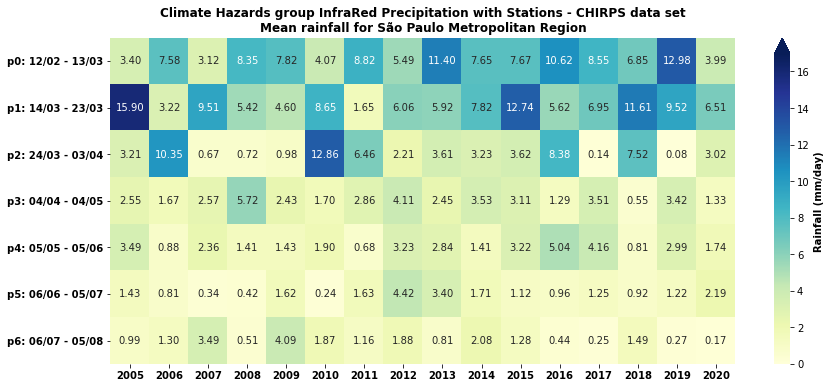

In [20]:
%%time

# Make figure.
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    data=df_mean_sp,
    vmin=0,
    vmax=17,
    cmap=plt.cm.YlGnBu,
    robust=True,
    annot=True,
    fmt=".2f",
    yticklabels=["p0: 12/02 - 13/03", 
                 "p1: 14/03 - 23/03",
                 "p2: 24/03 - 03/04",
                 "p3: 04/04 - 04/05",
                 "p4: 05/05 - 05/06",
                 "p5: 06/06 - 05/07",
                 "p6: 06/07 - 05/08"],
    cbar_kws={"extend": "max", "pad": 0.01}
)

# Adjustments.
ax.set_title(f"{DS.precipitation.long_name} - CHIRPS data set" + \
             "\nMean rainfall for São Paulo Metropolitan Region", weight="bold")
ax.set_xticklabels(ax.get_xticklabels(), weight="bold")
ax.set_yticklabels(ax.get_yticklabels(), weight="bold")
ax.collections[0].colorbar.set_label(f"Rainfall ({DS.precipitation.units})", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "precipitation_heatmap_sp_city_mean.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

CPU times: user 1.14 s, sys: 92 ms, total: 1.24 s
Wall time: 1.24 s


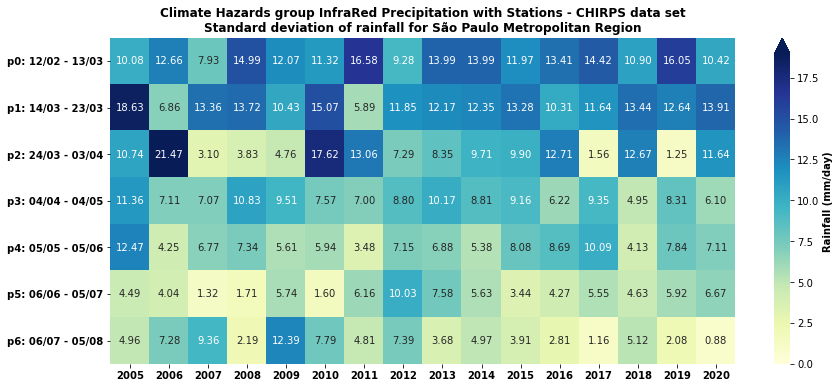

In [21]:
%%time

# Make figure.
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    data=df_std_sp,
    vmin=0,
    vmax=19,
    cmap=plt.cm.YlGnBu,
    robust=True,
    annot=True,
    fmt=".2f",
    yticklabels=["p0: 12/02 - 13/03", 
                 "p1: 14/03 - 23/03",
                 "p2: 24/03 - 03/04",
                 "p3: 04/04 - 04/05",
                 "p4: 05/05 - 05/06",
                 "p5: 06/06 - 05/07",
                 "p6: 06/07 - 05/08"],
    cbar_kws={"extend": "max"}
)

# Adjustments.
ax.set_title(f"{DS.precipitation.long_name} - CHIRPS data set" + \
             "\nStandard deviation of rainfall for São Paulo Metropolitan Region", weight="bold")
ax.set_xticklabels(ax.get_xticklabels(), weight="bold")
ax.set_yticklabels(ax.get_yticklabels(), weight="bold")
ax.collections[0].colorbar.set_label(f"Rainfall ({DS.precipitation.units})", weight="bold")

if save_fig:
    plt.savefig(
        FIG_PATH + "precipitation_heatmap_sp_city_std.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )